# 0.Input and alignment

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as an
from reComBat import reComBat



In [45]:
def plot(data,metadata,type='tsne',plot_mode='all',name=None):
    adata = an.AnnData(X=data,obs=metadata)

    if plot_mode == 'all':
        to_colour_by = ['FileName',
                        'sample_type',
                        'tissue_name',
                        'anatomical_location',
                        'anatomical_classification',
                        'patient_ID'
                        ]
    else:
        to_colour_by = [
                        'anatomical_classification',
                        ]

    if type == 'tsne':
        sc.tl.tsne(adata,use_rep='X')
        if name is not None:
            sc.pl.tsne(adata,color=to_colour_by,show=False,ncols=1,hspace=0.25,legend_fontsize=8,save='_'+name)
        else:
            sc.pl.tsne(adata,color=to_colour_by,show=True,ncols=1,hspace=0.25,legend_fontsize=8)
    elif type == 'umap':
        sc.pp.neighbors(adata,use_rep='X')
        sc.tl.umap(adata)
        if name is not None:
            sc.pl.umap(adata,color=to_colour_by,show=True,ncols=1,hspace=0.25,legend_fontsize=8,save='_'+name)
        else:
            sc.pl.umap(adata,color=to_colour_by,show=True,ncols=1,hspace=0.25,legend_fontsize=8)
    elif type == 'pca':
        sc.tl.pca(adata,use_highly_variable=False)
        if name is not None:
            sc.pl.pca(adata,color=to_colour_by,show=True,ncols=1,hspace=0.25,legend_fontsize=8,save='_'+name)
        else:
            sc.pl.pca(adata,color=to_colour_by,show=True,ncols=1,hspace=0.25,legend_fontsize=8)

In [8]:
df = pd.read_csv('//172.16.13.136/TPHP/results/rlt_combine_entraplib_G3/mapped_pg_matrix_1780_13795.csv')
info = pd.read_excel('//172.16.13.136/TPHP/results/rlt_combine_entraplib_G3/20250714_PUH_sample_information_1781files_info_edited_v9.xlsx')


In [ ]:
info_coarse  = info[['FileName',
                    'sample_type',
                    'tissue_name',
                    'anatomical_location',
                    'anatomical_classification',
                    'patient_ID']]

data = df.rename(columns={'Unnamed: 0': 'Filename'}).set_index('Filename') # each row is a file, each column is a protein
metadata = info_coarse.set_index('FileName') # each row is a file, each column is a metadata field


In [39]:
valid_ids = list(set(data.index).intersection(set(metadata.index)))
valid_ids.sort()
data_fit = data.loc[valid_ids]
metadata_fit = metadata.loc[valid_ids]

print(metadata_fit.shape)
print(data_fit.shape)

(1780, 5)
(1780, 13794)


In [44]:
assert np.array(data_fit.index == metadata_fit.index).all()

In [47]:
plot(data_fit,metadata_fit,type='tsne')


ValueError: Input X contains NaN.
TSNE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# 1.Initial assessment of data

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import QuantileTransformer, StandardScaler, normalize


In [48]:
print(f"Data matrix: {data_fit.shape[0]} runs × {data_fit.shape[1]} proteins")
print(f"Metadata table: {metadata_fit.shape[0]} runs × {metadata_fit.shape[1]} fields\n")


Data matrix: 1780 runs × 13794 proteins
Metadata table: 1780 runs × 5 fields



Missing values per run:
  • min = 4150, max = 13297, total = 12428513
Missing values per protein:
  • min = 0, max = 1779, total = 12428513



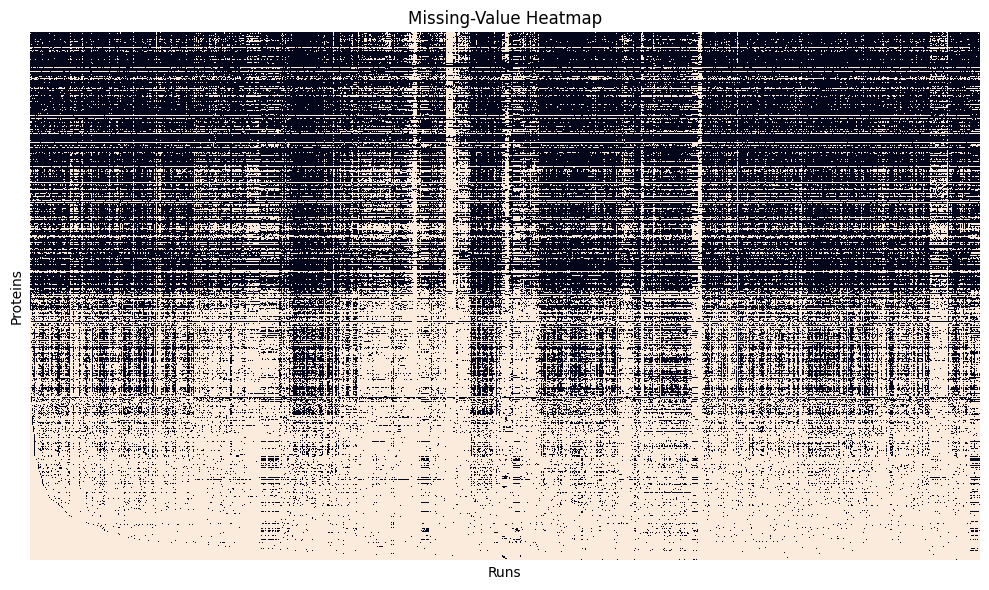

In [53]:
# Missing‐value summary
missing_by_run     = data_fit.isna().sum(axis=1)
missing_by_protein = data_fit.isna().sum(axis=0)
print("Missing values per run:")
print(f"  • min = {missing_by_run.min()}, max = {missing_by_run.max()}, total = {missing_by_run.sum()}")
print("Missing values per protein:")
print(f"  • min = {missing_by_protein.min()}, max = {missing_by_protein.max()}, total = {missing_by_protein.sum()}\n")

# Heatmap of missing values (runs × proteins)
plt.figure(figsize=(10, 6))
sns.heatmap(
    data_fit.T.isna(),
    cbar=False,
    xticklabels=False,
    yticklabels=False 
)
plt.title("Missing‐Value Heatmap")
plt.xlabel("Runs")
plt.ylabel("Proteins")
plt.tight_layout()
plt.show()

In [ ]:
# 1) Align to missing‐value matrix order
missings = data_fit.isna().T
ann = metadata_fit.loc[data_fit.index]

# 2) Proceed with the clustermap
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# Build color‐lookup tables (LUTs)
def make_lut(series):
    uniq = series.unique()
    palette = sns.color_palette(n_colors=len(uniq))
    return dict(zip(uniq, palette))

luts = {col: make_lut(ann[col]) 
        for col in ['patient_ID', 'sample_type', 'anatomical_classification'] 
        if col in ann.columns}

col_colors = sns.color_palette()  # placeholder if none, adjust below
if luts:
    import pandas as pd
    col_colors = pd.DataFrame({col: ann[col].map(luts[col]) 
                               for col in luts}, index=ann.index)

# Plot
g = sns.clustermap(
    missings,
    row_cluster=True, col_cluster=True,
    xticklabels=False,
    yticklabels=False,
    cmap="viridis", cbar_pos=None,
    col_colors=(col_colors if luts else None),
    figsize=(14, 10)
)

g.ax_heatmap.set_xticklabels(
    g.ax_heatmap.get_xticklabels(), rotation=90, fontsize=8
)
g.ax_heatmap.set_xlabel("Run (FileName)")
g.ax_heatmap.set_ylabel("Proteins")
plt.suptitle("Hierarchical Clustering of Missing‐Value Pattern", y=1.02)

# Legends
for i, (field, lut) in enumerate(luts.items()):
    handles = [Patch(color=c, label=v) for v, c in lut.items()]
    plt.legend(
        handles=handles, title=field,
        bbox_to_anchor=(1.02, 1 - i*0.15), loc='best',
        fontsize=8, title_fontsize=9, frameon=False
    )

plt.tight_layout()
plt.show()


c:\Users\dell\anaconda3\envs\reComBat\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


In [ ]:


# -----------------------------------------------------------------------------
# ASSUMPTION: data_fit and metadata_fit are preloaded pandas DataFrames:
#   • data_fit: shape (1780 runs × 13,794 proteins)
#   • metadata_fit: shape (1780 runs × m metadata fields)
# -----------------------------------------------------------------------------

# 1. INITIAL QUALITY ASSESSMENT
# -----------------------------------------------------------------------------

# 1.1 Data & metadata dimensions




# 1.3 Outlier detection (|Z| > 3 per run)
#    Compute Z‐scores along each run (row)
z_scores = data_fit.apply(lambda row: zscore(row, nan_policy='omit'), axis=1)
outliers = np.abs(z_scores) > 3
n_outliers = outliers.sum().sum()
print(f"Total outlier measurements (|Z|>3): {n_outliers}\n")

# 1.4 Descriptive statistics
print("Global summary statistics:")
print(data_fit.describe().T[['min', '25%', '50%', '75%', 'max']])
print()

# 1.5 Overall distribution of intensities
plt.figure(figsize=(8, 6))
sns.histplot(data_fit.values.flatten(), bins=100, kde=True)
plt.title("Distribution of All Protein Intensities")
plt.xlabel("Intensity")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 1.6 Sample–sample correlation matrix and clustering
corr_matrix = data_fit.T.corr()
sns.clustermap(corr_matrix, cmap='vlag', linewidths=0.5, figsize=(12, 10))
plt.suptitle("Sample–Sample Correlation Clustermap", y=1.02)
plt.show()

# -----------------------------------------------------------------------------
# 2. NORMALIZATION PIPELINE
# -----------------------------------------------------------------------------

# 2.1 Log₂(x + 1) transform to stabilize variance
data_log2 = np.log2(data_fit + 1)
print("Applied log2(x + 1) transformation.")

# 2.2 Quantile normalization to a Gaussian distribution
qt = QuantileTransformer(output_distribution='normal', copy=True, random_state=0)
data_qn = pd.DataFrame(
    qt.fit_transform(data_log2),
    index=data_log2.index,
    columns=data_log2.columns
)
print("Applied quantile normalization (to normal distribution).")

# 2.3 Standard scaling (zero mean, unit variance) across proteins
scaler = StandardScaler(copy=True)
data_scaled = pd.DataFrame(
    scaler.fit_transform(data_qn.T).T,
    index=data_qn.index,
    columns=data_qn.columns
)
print("Applied standard (Z‐score) scaling across proteins.")

# 2.4 Unit‐norm normalization per run
data_norm = pd.DataFrame(
    normalize(data_scaled, axis=1),
    index=data_scaled.index,
    columns=data_scaled.columns
)
print("Applied unit‐norm normalization per run.\n")

# 2.5 Save normalized matrix
output_path = "normalized_proteomics_data.csv"
data_norm.to_csv(output_path)
print(f"Normalization complete. Saved normalized data to '{output_path}'.")
